In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import tensorflow as tf
import os
from PIL import Image, ImageDraw
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import os
import io
from google.colab import files
from IPython.display import display

zip_file_path = '/content/drive/My Drive/archive (1).zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content')  # Extract to the Colab root directory

# Checking the contents of the extracted folder
print(os.listdir('/content'))

tflite_model_path = '/content/drive/My Drive/model.tflite'

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)  # Replace with your TFLite model path
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_image(image_path, input_size):
    # Load the image
    img = load_img(image_path, target_size=input_size)

    # Convert to array
    img = img_to_array(img)

    # Normalize the image
    img = img / 255.0

    # Check if the image has 3 channels (RGB)
    if img.shape[-1] == 3:
        # Reshape from (height, width, channels) to (1, channels, height, width)
        img = np.transpose(img, (2, 0, 1))
        img = np.expand_dims(img, axis=0)
    else:
        raise ValueError("Image does not have 3 channels")

    return img

input_size = (416, 416)  # height and width
# Post-processing function
def decode_predictions(raw_output, num_classes=19, confidence_threshold=0.1, iou_threshold=0.5):
    # Split the output into boxes, objectness scores, and class probabilities
    boxes = raw_output[..., :4]   # Bounding box coordinates
    objectness = raw_output[..., 4:5]  # Objectness scores
    class_probs = raw_output[..., 5:]  # Class probabilities

    # Apply sigmoid to boxes, objectness scores, and class probabilities
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)

    # Compute scores by multiplying objectness with class probabilities
    scores = objectness * class_probs

     # Flatten the scores and boxes for filtering
    scores_flat = tf.reshape(scores, [-1, num_classes])
    boxes_flat = tf.reshape(boxes, [-1, 4])

    # Filter out low-confidence predictions
    max_scores = tf.reduce_max(scores_flat, axis=-1)
    mask = max_scores > confidence_threshold
    filtered_scores = tf.boolean_mask(scores_flat, mask)
    filtered_boxes = tf.boolean_mask(boxes_flat, mask)
    max_scores = tf.boolean_mask(max_scores, mask)
    # Apply Non-Maximum Suppression
    selected_indices = tf.image.non_max_suppression(
        filtered_boxes, max_scores, max_output_size=filtered_boxes.shape[0], iou_threshold=iou_threshold
    )

    # Get the top-scoring box index (the one with the highest score after NMS)
    top_scoring_box_index = tf.argmax(max_scores.numpy()[selected_indices])

    # Select only the top-scoring box
    final_box = tf.gather(filtered_boxes, selected_indices)[top_scoring_box_index].numpy()
    final_score = tf.gather(max_scores, selected_indices)[top_scoring_box_index].numpy()
    classes = tf.argmax(filtered_scores, axis=-1)
    final_class = tf.gather(classes, selected_indices)[top_scoring_box_index].numpy()

    # Convert to required format: [(box, class index, score), ...]
    predictions = [(final_box, final_class, final_score)]

    return predictions





# Function to draw boxes on the image
def draw_boxes(original_image, predictions, input_size):

    classes = [
    "Aluminium foil", "Bottle", "Bottle cap", "Broken glass", "Can",
    "Carton", "Cigarette", "Cup", "Lid", "Other litter",
    "Other plastic", "Paper", "Plastic bag & wrapper", "Plastic bag - wrapper",
    "Plastic container", "Pop tab", "Straw", "Styrofoam piece", "Unlabeled litter"
          ]

    width, height = original_image.size
    draw = ImageDraw.Draw(original_image)

    # Calculate scaling factors
    x_scale = width / input_size[1]
    y_scale = height / input_size[0]

    for box, class_id, score in predictions:
        # Scale box to original image size
        xmin, ymin, xmax, ymax = box
        xmin = int(xmin * x_scale)
        ymin = int(ymin * y_scale)
        xmax = int(xmax * x_scale)
        ymax = int(ymax * y_scale)

        score = score[class_id] if score.ndim > 0 else score

        # Draw the bounding box
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

        # Format the score to two decimal places
        score_text = "{:.2f}".format(score)

        # Annotate the bounding box with class_id and score
        draw.text((xmin, ymin), f"{classes[class_id]} {score_text}", fill="black")

    return original_image


predicted_class_ids = {}



for image_name in os.listdir(test_images_dir):
    image_path = os.path.join(test_images_dir, image_name)
    input_data = preprocess_image(image_path, input_size)

    # Set the input tensor for the TFLite interpreter
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the model's output
    raw_output = interpreter.get_tensor(output_details[0]['index'])[0]  # Get the raw output from the model
    predictions = decode_predictions(raw_output)  # Decode the raw output

    # Load the original image (not preprocessed)
    original_image = Image.open(image_path)
    input_size = (416,416)
    # Draw boxes on the original image
    result_image = draw_boxes(original_image, predictions, input_size)

    if predictions:
      # Use the final_class directly from the predictions
      final_class = predictions[0][1]  # (box, class_id, score)
      predicted_class_ids[image_name.replace('.jpg', '')] = final_class


    # Display the image with bounding boxes
    #display(result_image)





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.config', 'PXL_20231210_014958894 (1).jpg', 'PXL_20231210_014958894.jpg', 'data.yaml', 'drive', 'PXL_20231210_014958894 (2).jpg', 'test', 'train', 'README.dataset.txt', 'PXL_20231210_015015538 (1).jpg', 'PXL_20231210_014958894 (3).jpg', 'PXL_20231210_015015538 (2).jpg', 'PXL_20231210_014958894 (4).jpg', 'PXL_20231210_021556561~2.jpg', 'PXL_20231210_021556561~2 (1).jpg', 'PXL_20231210_015015538.jpg', 'valid', 'model.tflite', 'PXL_20231210_014958894 (5).jpg', 'README.roboflow.txt', 'PXL_20231210_021556561.jpg', 'sample_data']


In [ ]:
import glob
import os

# Path to the directory containing label files
label_dir = '/content/test/labels'  # Adjust as needed

# Get all label files
label_files = glob.glob(os.path.join(label_dir, '*.txt'))

# Initialize a dictionary to hold image file names to their ground truth class IDs
ground_truths = {}

# Iterate over the label files
for file_path in label_files:
    base_name = os.path.basename(file_path).replace('.txt', '')
    with open(file_path, 'r') as file:
        lines = file.readlines()
        class_ids = [int(line.split()[0]) for line in lines]
        ground_truths[base_name] = class_ids


def calculate_accuracy(ground_truths, predicted_class_ids):
    correct_predictions = 0

    for image_name, predicted_class_id in predicted_class_ids.items():
        if predicted_class_id in ground_truths.get(image_name, []):
            correct_predictions += 1

    accuracy = correct_predictions / len(predicted_class_ids) if predicted_class_ids else 0
    return accuracy

# Calculate the accuracy
accuracy = calculate_accuracy(ground_truths, predicted_class_ids)
print(f"Accuracy: {accuracy:.2f}")




Accuracy: 0.90


Saving PXL_20231210_021556561~2.jpg to PXL_20231210_021556561~2 (2).jpg


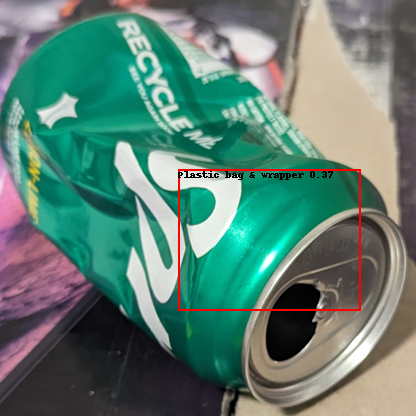

In [ ]:
from google.colab import files
uploaded = files.upload()

# Assuming you want to process a single image
# Get the file name of the first uploaded file
filename = next(iter(uploaded))

# Preprocess the uploaded image
input_data = preprocess_image(filename, input_size)

# Set the input tensor for the TFLite interpreter
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the model's output
raw_output = interpreter.get_tensor(output_details[0]['index'])[0]
predictions = decode_predictions(raw_output)

# Load the original image (not preprocessed)
original_image = Image.open(filename)
input_size = (416, 416)

resized_image = original_image.resize((416, 416))

# Draw boxes on the original image
result_image = draw_boxes(resized_image, predictions, input_size)

# Display the image with bounding boxes
display_size = (416,416)
display(result_image)

